Correlation Matrix:
                avg_rating  avg_votes  avg_box_office
avg_rating        1.000000  -0.259565       -0.024418
avg_votes        -0.259565   1.000000        0.682402
avg_box_office   -0.024418   0.682402        1.000000


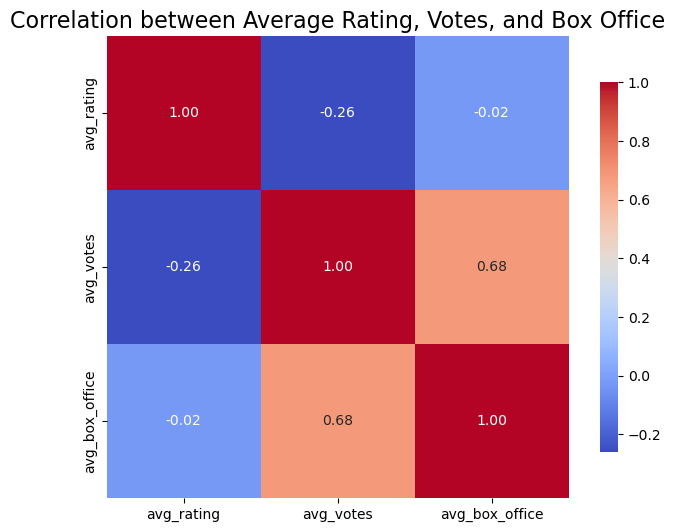

Top Genres by Average Box Office Earnings (Last 10 Years):
        Genre  avg_rating      avg_votes  avg_box_office
2   Animation    6.742105  137257.957895    1.397017e+08
1   Adventure    6.499600  266824.980000    1.327446e+08
8      Family    6.545455   59713.272727    6.007196e+07
0      Action    6.333971  151265.784689    4.677430e+07
15     Sci-Fi    6.198667  177581.866667    4.548199e+07
5       Crime    6.549153  138295.000000    3.391803e+07


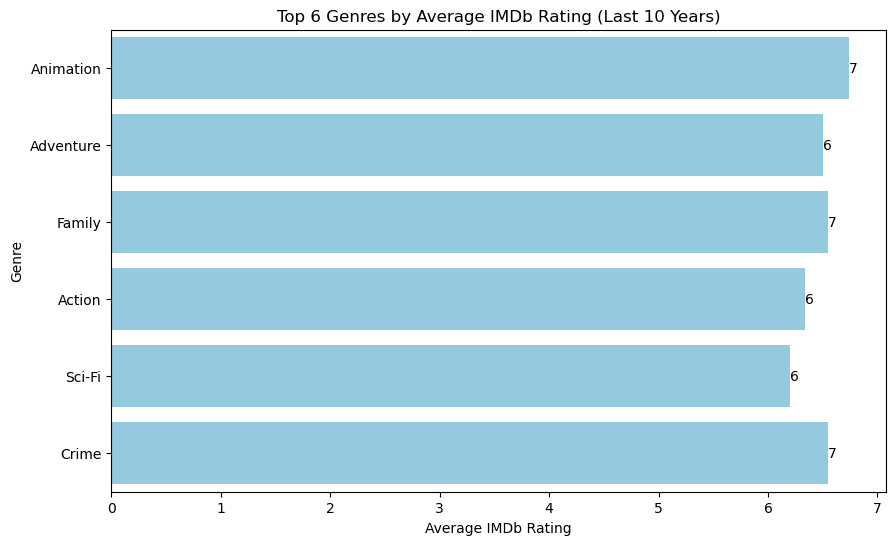

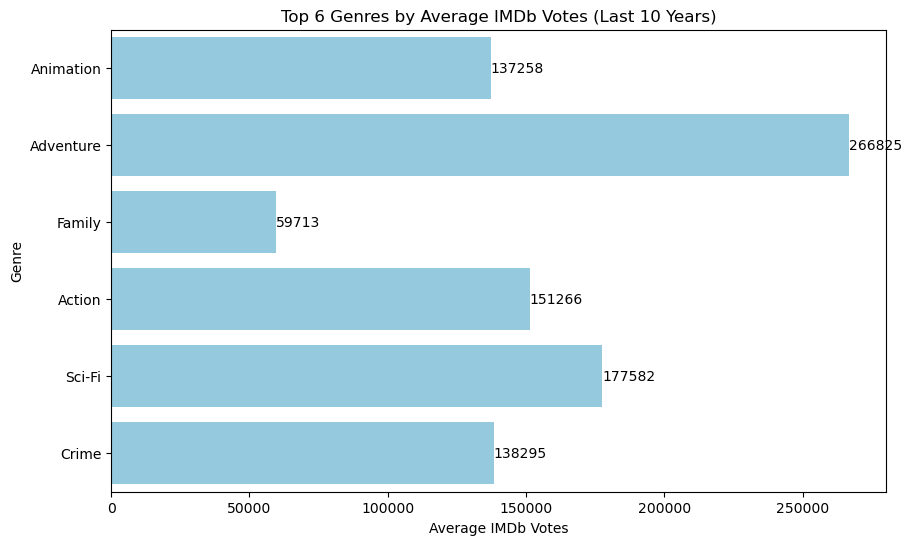

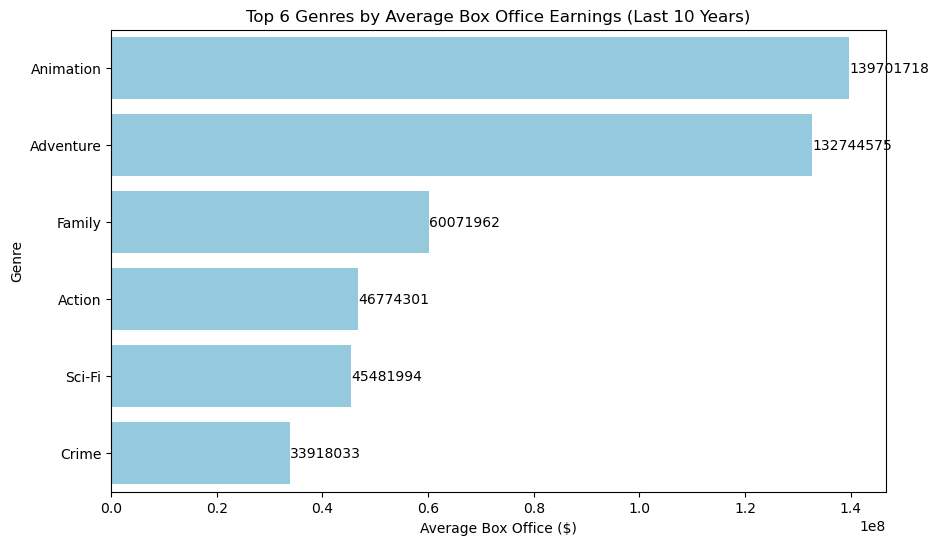

Correlation Matrix between Actor Popularity and Box Office:
                       normalized_rating  normalized_votes  \
normalized_rating               1.000000          0.158251   
normalized_votes                0.158251          1.000000   
normalized_box_office           0.101481          0.872208   

                       normalized_box_office  
normalized_rating                   0.101481  
normalized_votes                    0.872208  
normalized_box_office               1.000000  


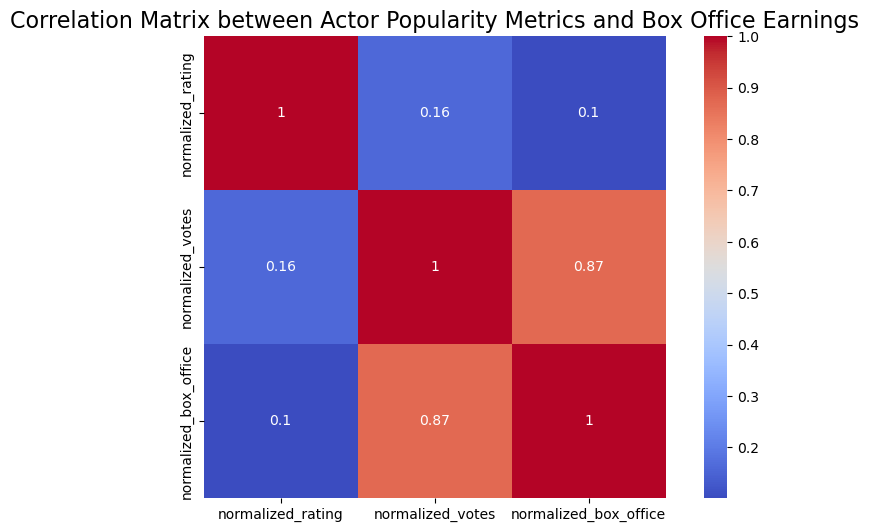

             Lead_Actor  num_movies  avg_rating  total_votes  \
1948          Tom Hanks          32    7.162500     12876434   
1943         Tom Cruise          31    7.035484     10479956   
1214  Leonardo DiCaprio          18    7.561111     13910954   
357      Christian Bale          20    7.265000     11985178   
226           Brad Pitt          19    7.268421     10061632   
...                 ...         ...         ...          ...   
1056      Julia Sweeney           1    2.800000        10548   
134      Anthony Newley           1    2.700000         8818   
665         Gary Graham           1    2.500000        15136   
32          Albie Hecht           1    2.400000          243   
1522       Paris Hilton           1    2.000000        39184   

      total_box_office  normalized_rating  normalized_votes  \
1948        4120929291           0.770522          0.925632   
1943        4087880697           0.751565          0.753358   
1214        2329220035           0.830017 

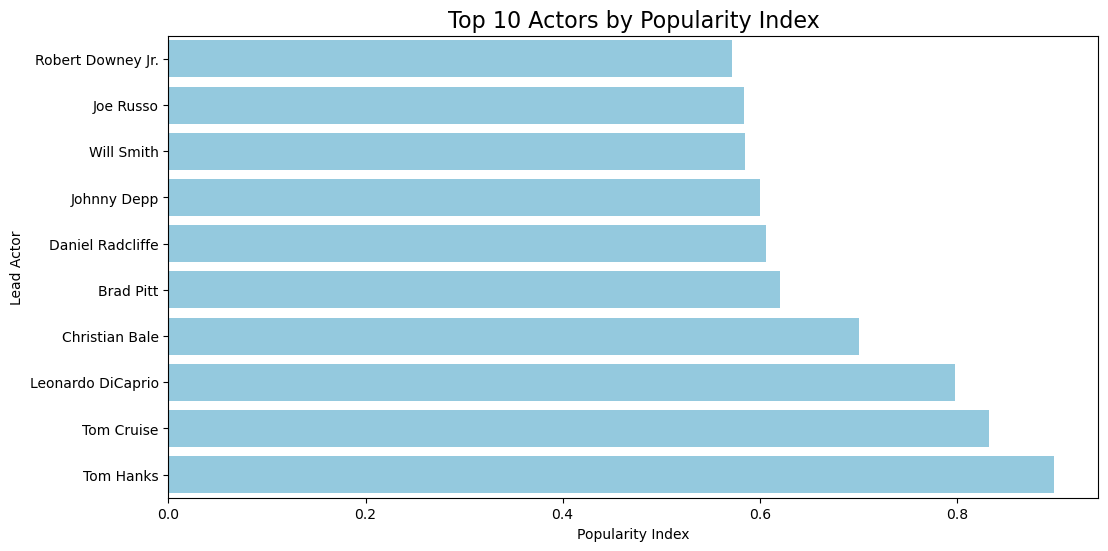

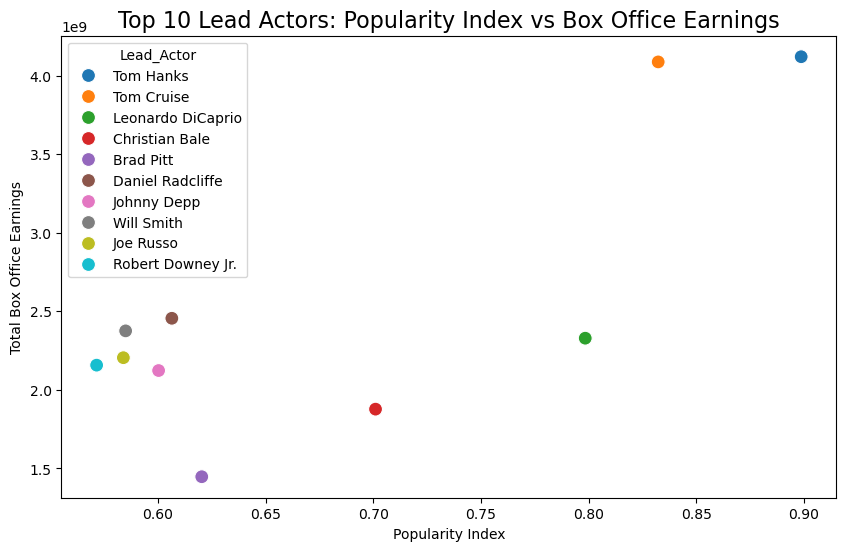


Average BoxOffice by Runtime Category:
Runtime_Category
120-150 min    7.686788e+07
150-180 min    9.603365e+07
180-210 min    1.285707e+08
90-120 min     4.106020e+07
< 90 min       3.472526e+07
> 210 min      3.288634e+07
Name: BoxOffice, dtype: float64


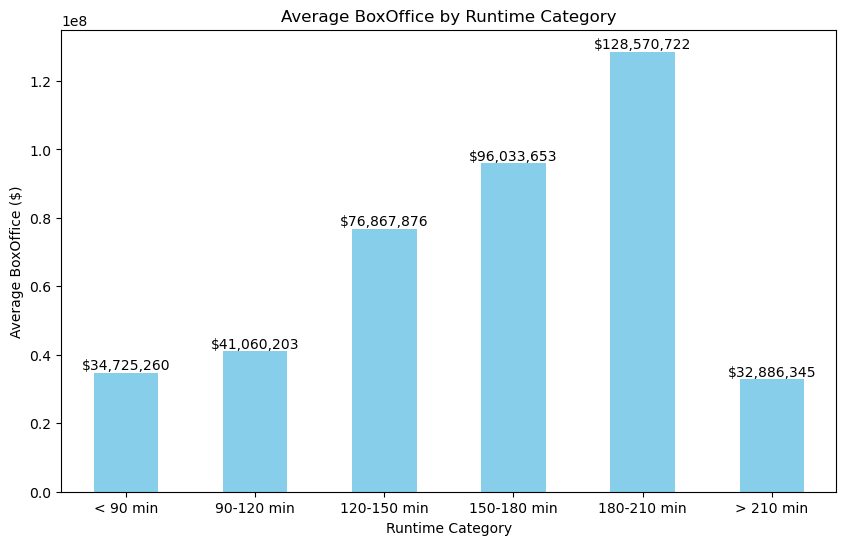

In [48]:
import pandas as pd
import requests
import time
import csv
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

#Read data file
url = '/Users/rishikeshdhokare/Downloads/MergedDataSet/Final/final_omdb_data_no_duplicates.csv'
df = pd.read_csv(url)

############################################# Hypothesis 1 ##########################################################

df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
recent_years_df = df[df['Year'] >= (df['Year'].max() - 10)]

recent_years_df = recent_years_df.assign(Genre=recent_years_df['Genre'].str.split(',')).explode('Genre')
recent_years_df['Genre'] = recent_years_df['Genre'].str.strip()  

recent_years_df['BoxOffice'] = pd.to_numeric(recent_years_df['BoxOffice'].replace(r'[\$,]', '', regex=True), errors='coerce')
recent_years_df['imdbVotes'] = pd.to_numeric(recent_years_df['imdbVotes'].replace(',', '', regex=True), errors='coerce')

# Calculate average metrics
genre_statistics_recent_df = recent_years_df.groupby('Genre').agg(
    avg_rating=('imdbRating', 'mean'),      
    avg_votes=('imdbVotes', 'mean'),        
    avg_box_office=('BoxOffice', 'mean')
).reset_index()

# Correlation between Rating, Votes, and Box Office
correlation_matrix = genre_statistics_recent_df[['avg_rating', 'avg_votes', 'avg_box_office']].corr()
print("Correlation Matrix:")
print(correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation between Average Rating, Votes, and Box Office', fontsize=16)
plt.show()

# Sort genres by average box office earnings
genre_sorted_by_box_office = genre_statistics_recent_df.sort_values(by='avg_box_office', ascending=False).head(6)
print("Top Genres by Average Box Office Earnings (Last 10 Years):")
print(genre_sorted_by_box_office)

# Bar chart for average rating by Genre
plt.figure(figsize=(10, 6))
sns.barplot(x='avg_rating', y='Genre', data=genre_sorted_by_box_office, color='skyblue')
plt.xlabel('Average IMDb Rating')
plt.ylabel('Genre')
plt.title('Top 6 Genres by Average IMDb Rating (Last 10 Years)')
for index, value in enumerate(genre_sorted_by_box_office['avg_rating']):
    plt.text(value, index, f'{value:.0f}', va='center')
plt.show()

# Bar chart for average votes by Genre
plt.figure(figsize=(10, 6))
sns.barplot(x='avg_votes', y='Genre', data=genre_sorted_by_box_office, color='skyblue')
plt.xlabel('Average IMDb Votes')
plt.ylabel('Genre')
plt.title('Top 6 Genres by Average IMDb Votes (Last 10 Years)')
for index, value in enumerate(genre_sorted_by_box_office['avg_votes']):
    plt.text(value, index, f'{value:.0f}', va='center')
plt.show()

# Bar chart for average box office earnings by Genre
plt.figure(figsize=(10, 6))
sns.barplot(x='avg_box_office', y='Genre', data=genre_sorted_by_box_office, color='skyblue')
plt.xlabel('Average Box Office ($)')
plt.ylabel('Genre')
plt.title('Top 6 Genres by Average Box Office Earnings (Last 10 Years)')
for index, value in enumerate(genre_sorted_by_box_office['avg_box_office']):
    plt.text(value, index, f'{value:.0f}', va='center')
plt.show()

############################################# Hypothesis 2 ##########################################################

df['BoxOffice'] = pd.to_numeric(df['BoxOffice'].replace(r'[\$,]', '', regex=True), errors='coerce')
df['imdbVotes'] = pd.to_numeric(df['imdbVotes'].replace(',', '', regex=True), errors='coerce')
df['Lead_Actor'] = df['Actor'].str.split(',').str[0].str.strip()

lead_actor_statistics_df = df.groupby('Lead_Actor').agg(
    num_movies=('Title', 'count'),
    avg_rating=('imdbRating', 'mean'),
    total_votes=('imdbVotes', 'sum'),
    total_box_office=('BoxOffice', 'sum')
).reset_index()

scaler = MinMaxScaler()
lead_actor_statistics_df.dropna(subset=['avg_rating', 'total_votes', 'total_box_office'], inplace=True)

lead_actor_statistics_df[['normalized_rating', 'normalized_votes', 'normalized_box_office']] = scaler.fit_transform(
    lead_actor_statistics_df[['avg_rating', 'total_votes', 'total_box_office']]
)

# Popularity index by averaging the normalized metrics
lead_actor_statistics_df['popularity_index'] = (lead_actor_statistics_df['normalized_rating'] + 
                                                lead_actor_statistics_df['normalized_votes'] + 
                                                lead_actor_statistics_df['normalized_box_office']) / 3

# Correlation analysis between popularity metrics and box office
correlation_matrix = lead_actor_statistics_df[['normalized_rating', 'normalized_votes', 'normalized_box_office']].corr()
print("Correlation Matrix between Actor Popularity and Box Office:")
print(correlation_matrix)

# Scatter plot for normalized popularity vs box office earnings
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", square=True)
plt.title("Correlation Matrix between Actor Popularity Metrics and Box Office Earnings", fontsize=16)
plt.show()

most_famous_lead_actor_df = lead_actor_statistics_df.sort_values(by='popularity_index', ascending=False)
print(most_famous_lead_actor_df)

# Bar plot for Top 10 Actors by Popularity Index
plt.figure(figsize=(12, 6))
sns.barplot(x='popularity_index', y='Lead_Actor', data=most_famous_lead_actor_df.head(10), color='skyblue')
plt.title("Top 10 Actors by Popularity Index", fontsize=16)
plt.xlabel("Popularity Index")
plt.ylabel("Lead Actor")
plt.gca().invert_yaxis()
plt.show()

# Scatter plot for Top 10 Lead Actors' Popularity vs Box Office
plt.figure(figsize=(10, 6))
sns.scatterplot(x='popularity_index', y='total_box_office', data=most_famous_lead_actor_df.head(10), hue='Lead_Actor', s=100)
plt.title('Top 10 Lead Actors: Popularity Index vs Box Office Earnings', fontsize=16)
plt.xlabel('Popularity Index')
plt.ylabel('Total Box Office Earnings')
plt.show()

############################################# Hypothesis 3 ##########################################################
df['BoxOffice'] = df['BoxOffice'].replace({r'\$': '', r',': ''}, regex=True)
df['BoxOffice'] = pd.to_numeric(df['BoxOffice'], errors='coerce')

df['Runtime'] = pd.to_numeric(df['Runtime'], errors='coerce')

def classify_runtime(runtime):
    if pd.isna(runtime):
        return 'Unknown'
    if runtime < 90:
        return '< 90 min'
    elif 90 <= runtime < 120:
        return '90-120 min'
    elif 120 <= runtime < 150:
        return '120-150 min'
    elif 150 <= runtime < 180:
        return '150-180 min'
    elif 180 <= runtime < 210:
        return '180-210 min'
    else:
        return '> 210 min'

df['Runtime_Category'] = df['Runtime'].apply(classify_runtime)
runtime_boxoffice_avg = df.groupby('Runtime_Category')['BoxOffice'].mean()
print("\nAverage BoxOffice by Runtime Category:")
print(runtime_boxoffice_avg)

categories = ['< 90 min','90-120 min','120-150 min', '150-180 min', '180-210 min', '> 210 min']
for category in categories:
    if category not in runtime_boxoffice_avg:
        runtime_boxoffice_avg[category] = None

# Order runtime categories
runtime_boxoffice_avg = runtime_boxoffice_avg.reindex(['< 90 min', '90-120 min', '120-150 min', 
                                                      '150-180 min', '180-210 min', '> 210 min'])

# Graph
plt.figure(figsize=(10, 6))
runtime_boxoffice_avg.plot(kind='bar', color=['skyblue'])
plt.title('Average BoxOffice by Runtime Category')
plt.xlabel('Runtime Category')
plt.ylabel('Average BoxOffice ($)')
plt.xticks(rotation=0)

# Adding text annotations for the bar values
for i in range(len(runtime_boxoffice_avg)):
    plt.text(i, runtime_boxoffice_avg.iloc[i], 
             f"${runtime_boxoffice_avg.iloc[i]:,.0f}" if pd.notna(runtime_boxoffice_avg.iloc[i]) else 'N/A', 
             ha='center', va='bottom')
plt.show()